In [384]:
# data munging and visualization
import numpy as np
import pandas as pd
import itertools


# class imbalance treatment
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


# visualization
import matplotlib.pyplot as plt
%matplotlib inline


# feature engineering
import featuretools as ft


# predictor -> classification, regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score


# miscellanous
import datetime
import os

## Users

In [385]:
users = pd.read_csv('data/users_Feb_1_30days_cohort.csv')
users['bux_account_created_dts'] = pd.to_datetime(users['bux_account_created_dts'])
users = users[users.columns[1:]]
len(users)

58839

In [386]:
sample_users = False
sample_num = 15000

if sample_users:
    users = users[0:sample_num]

len(users)

58839

In [387]:
users.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits
0,031b0f17-9a45-4b1b-b7b4-027802ffad95,DE,MALE,DE,iOS,SOME,Experienced Trader,Appnext,2017-02-03 21:10:20.056,SERIOUS_BUX,2017-02-13 22:11:52.000,450.0,450.0,1.0
1,010e236f-8ab5-4681-a146-273531d19d54,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 16:33:27.777,FUN_BUX,NaN,NaN,NaN,NaN
2,011f6526-ab7e-4790-b289-5fa1faf69bc3,AT,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-26 11:55:06.928,FUN_BUX,NaN,NaN,NaN,NaN
3,0231bd62-6733-4f8b-9c57-87f4eb9e0aa1,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-17 23:14:11.280,FUN_BUX,NaN,NaN,NaN,NaN
4,028e03b9-ab6d-4ede-85f2-ce6b6e38ad47,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-20 10:30:34.584,FUN_BUX,NaN,NaN,NaN,NaN


In [388]:
users['bux_account_created_day'] = [ts.day for ts in users['bux_account_created_dts']]
users['bux_account_created_day'].head()

0     3
1     1
2    26
3    17
4    20
Name: bux_account_created_day, dtype: int64

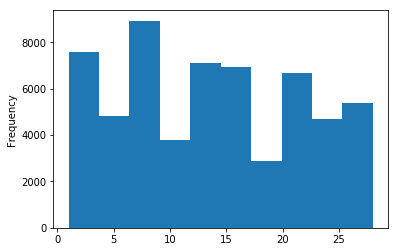

In [389]:
users['bux_account_created_day'].plot(kind='hist');

## Cube daily user

In [390]:
transactions = pd.read_csv('data/cube_daily_user_Feb_1_30days_cohort.csv')
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions[transactions.columns[1:]]
transactions = transactions.reset_index()
transactions.head()

,index,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,0,000c5e5d-4e25-412d-951b-31167045eb95,60,2017-03-01,0,0,FUN_BUX,0,0.0,0,Following,0
1,1,000c5e5d-4e25-412d-951b-31167045eb95,61,2017-03-02,0,0,FUN_BUX,0,0.0,0,Following,0
2,2,000c5e5d-4e25-412d-951b-31167045eb95,62,2017-03-03,0,0,FUN_BUX,0,0.0,0,Following,0
3,3,000c5e5d-4e25-412d-951b-31167045eb95,65,2017-03-06,0,0,FUN_BUX,0,0.0,0,Following,0
4,4,000c5e5d-4e25-412d-951b-31167045eb95,66,2017-03-07,0,0,FUN_BUX,0,0.0,0,Following,0


In [391]:
len(transactions), len(transactions['user_id'].unique()), len(transactions.columns)

(370117, 58045, 12)

In [392]:
transactions = transactions[transactions['user_id'].isin(users['user_id'])]
len(transactions)

370117

## Target values (Current customer value - CurCV)

In [393]:
CurCV = pd.read_csv('data/curCv_Feb_1_30days_cohort.csv')
CurCV["curcv"] = CurCV["com"] + CurCV["ff"]
CurCV = CurCV[['user_id', 'curcv']]
CurCV = CurCV.fillna(0)
CurCV.head()

,user_id,curcv
0,3e675443-9762-4137-b92e-3cbcea38e44a,0.0
1,0de77d85-f73d-4798-90e2-7bc4de4f74dd,0.0
2,6f40a1bf-1d49-4d6a-8c6f-683526189f9e,0.0
3,20544428-b6fa-46be-9b82-25d064e3650f,0.0
4,076e3239-a377-4cbb-81ed-8f16a3197a5d,0.0


In [394]:
CurCV["curcv"].describe()

count    58839.000000
mean         6.510799
std        210.954290
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      39186.110000
Name: curcv, dtype: float64

In [395]:
CurCV = CurCV[CurCV['user_id'].isin(users['user_id'])]
len(CurCV)

58839

## Define entities, entity tables and relationships

In [396]:
users[0:5]

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits,bux_account_created_day
0,031b0f17-9a45-4b1b-b7b4-027802ffad95,DE,MALE,DE,iOS,SOME,Experienced Trader,Appnext,2017-02-03 21:10:20.056,SERIOUS_BUX,2017-02-13 22:11:52.000,450.0,450.0,1.0,3
1,010e236f-8ab5-4681-a146-273531d19d54,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 16:33:27.777,FUN_BUX,NaN,NaN,NaN,NaN,1
2,011f6526-ab7e-4790-b289-5fa1faf69bc3,AT,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-26 11:55:06.928,FUN_BUX,NaN,NaN,NaN,NaN,26
3,0231bd62-6733-4f8b-9c57-87f4eb9e0aa1,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-17 23:14:11.280,FUN_BUX,NaN,NaN,NaN,NaN,17
4,028e03b9-ab6d-4ede-85f2-ce6b6e38ad47,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-20 10:30:34.584,FUN_BUX,NaN,NaN,NaN,NaN,20


In [397]:
transactions[0:5]

,index,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,0,000c5e5d-4e25-412d-951b-31167045eb95,60,2017-03-01,0,0,FUN_BUX,0,0.0,0,Following,0
1,1,000c5e5d-4e25-412d-951b-31167045eb95,61,2017-03-02,0,0,FUN_BUX,0,0.0,0,Following,0
2,2,000c5e5d-4e25-412d-951b-31167045eb95,62,2017-03-03,0,0,FUN_BUX,0,0.0,0,Following,0
3,3,000c5e5d-4e25-412d-951b-31167045eb95,65,2017-03-06,0,0,FUN_BUX,0,0.0,0,Following,0
4,4,000c5e5d-4e25-412d-951b-31167045eb95,66,2017-03-07,0,0,FUN_BUX,0,0.0,0,Following,0


In [398]:
CurCV.head()

,user_id,curcv
0,3e675443-9762-4137-b92e-3cbcea38e44a,0.0
1,0de77d85-f73d-4798-90e2-7bc4de4f74dd,0.0
2,6f40a1bf-1d49-4d6a-8c6f-683526189f9e,0.0
3,20544428-b6fa-46be-9b82-25d064e3650f,0.0
4,076e3239-a377-4cbb-81ed-8f16a3197a5d,0.0


In [399]:
es = ft.EntitySet("bux_cltv")

In [400]:
es.entity_from_dataframe(entity_id='users',
                        dataframe=users,
                        index='user_id',
                        time_index='bux_account_created_dts')

Entityset: bux_cltv
  Entities:
    users (shape = [58839, 15])
  Relationships:
    No relationships

In [401]:
es.entity_from_dataframe(entity_id='transactions',
                        dataframe=transactions,
                        index='index',
                        time_index='date')

Entityset: bux_cltv
  Entities:
    users (shape = [58839, 15])
    transactions (shape = [370117, 12])
  Relationships:
    No relationships

In [402]:
es.add_relationship(ft.Relationship(es['users']['user_id'], es['transactions']['user_id']))

Entityset: bux_cltv
  Entities:
    users (shape = [58839, 15])
    transactions (shape = [370117, 12])
  Relationships:
    transactions.user_id -> users.user_id

## Building labels

In [403]:
# rebalancing (R), visualization
# https://shiring.github.io/machine_learning/2017/04/02/unbalanced

- #### First, we'll separate observations from each class into different DataFrames.
- #### Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
- #### Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [404]:
# 70 euros 1 year customer value-> a user whale or not whale
whale_threshold = CurCV['curcv'].quantile(0.99)
whale_threshold

53.242400000000046

In [405]:
CurCV['whale'] = (CurCV['curcv'] > whale_threshold).astype(int)

In [406]:
CurCV['whale'].value_counts()

0    58250
1      589
Name: whale, dtype: int64

In [407]:
# number of whales
whales = CurCV[CurCV['curcv'] >= whale_threshold]
len(whales)

589

In [408]:
non_whales = CurCV[CurCV['curcv'] < whale_threshold]
len(non_whales)

58250

In [409]:
# 6m CV
CurCV['curcv'].mean(), CurCV['curcv'].median()

(6.510798789918253, 0.0)

In [410]:
# cohort value
CurCV['curcv'].sum()

383088.8900000001

In [411]:
# max value
CurCV['curcv'].max()

39186.110000000001

In [412]:
CurCV.head()

,user_id,curcv,whale
0,3e675443-9762-4137-b92e-3cbcea38e44a,0.0,0
1,0de77d85-f73d-4798-90e2-7bc4de4f74dd,0.0,0
2,6f40a1bf-1d49-4d6a-8c6f-683526189f9e,0.0,0
3,20544428-b6fa-46be-9b82-25d064e3650f,0.0,0
4,076e3239-a377-4cbb-81ed-8f16a3197a5d,0.0,0


In [413]:
len(CurCV[CurCV["user_id"] == "70c15a3e-b516-4aca-bea2-aa909a4a16d2"])

1

In [414]:
# Separate majority and minority classes
CurCV_majority = CurCV[CurCV["whale"] == 0 ]
CurCV_minority = CurCV[CurCV["whale"] == 1 ]
 
# Upsample minority class
CurCV_minority_upsampled = resample(CurCV_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(CurCV[CurCV["whale"] == 0]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
CurCV_upsampled = pd.concat([CurCV_majority, CurCV_minority_upsampled])
 
# Display new class counts
CurCV_upsampled["whale"].value_counts()

1    58250
0    58250
Name: whale, dtype: int64

In [415]:
len(CurCV_upsampled[CurCV_upsampled["user_id"] == "70c15a3e-b516-4aca-bea2-aa909a4a16d2"])

93

In [416]:
# CurCV['whale'].plot(kind='bar')

- Training window = the amount of historical data we want to use when calculating features
- cutoff_time = the point in time to calculate the features

We use cutoff times to avoid the risk of leaking labels into prediction

In [417]:
min(transactions['date'].unique()), max(transactions['date'].unique())

(numpy.datetime64('2017-02-01T00:00:00.000000000'),
 numpy.datetime64('2017-03-22T00:00:00.000000000'))

In [418]:
"""

cutoff_time = pd.Timestamp('Feb 10, 2017')
# 1 month prediction window
prediction_window = ft.Timedelta("3 weeks")
# 6 months of training data
training_window = ft.Timedelta("10 days")

prediction_window_end = cutoff_time + prediction_window
t_start = cutoff_time - training_window


cutoff_time = pd.Timestamp('Mar 1, 2017')
# 1 month prediction window
prediction_window = ft.Timedelta("1 day")
# 6 months of training data
training_window = ft.Timedelta("4 weeks")

prediction_window_end = cutoff_time + prediction_window
t_start = cutoff_time - training_window
prediction_window_end

t_start
transactions.head()

"""

'\n\ncutoff_time = pd.Timestamp(\'Feb 10, 2017\')\n# 1 month prediction window\nprediction_window = ft.Timedelta("3 weeks")\n# 6 months of training data\ntraining_window = ft.Timedelta("10 days")\n\nprediction_window_end = cutoff_time + prediction_window\nt_start = cutoff_time - training_window\n\n\ncutoff_time = pd.Timestamp(\'Mar 1, 2017\')\n# 1 month prediction window\nprediction_window = ft.Timedelta("1 day")\n# 6 months of training data\ntraining_window = ft.Timedelta("4 weeks")\n\nprediction_window_end = cutoff_time + prediction_window\nt_start = cutoff_time - training_window\nprediction_window_end\n\nt_start\ntransactions.head()\n\n'

In [419]:
# transactions sorted by the date
trans = es['transactions'].df
trans['date'][0:5]

index
1791   2017-02-01
3120   2017-02-01
3165   2017-02-01
3225   2017-02-01
3306   2017-02-01
Name: date, dtype: datetime64[ns]

In [420]:
# # get the first launch of a user
# # user_created = pd.DataFrame(trans.groupby('user_id')['date'].min()).reset_index()

# user_last_event_last = pd.DataFrame(trans.groupby('user_id')['date'].max()).reset_index()
# user_last_event_last = user_last_event_last['date'].max()
# user_last_event_last

In [421]:
# cutoff_time = '2017-02-20'
# users_in_training = user_created[user_created['date'] < cutoff_time]['user_id']
# len(users_in_training)

In [422]:
# training_data = trans[trans['user_id'].isin(users_in_training)]
# validation_data = trans[~trans['user_id'].isin(users_in_training)]

In [423]:
# len(training_data)

In [424]:
# len(validation_data)

In [425]:
# # the raw feature values
# training_data = trans[(trans['date'] <= cutoff_time) & (trans['date'] > t_start)]
# # to compute the label
# prediction_data = trans[(trans['date'] > cutoff_time) & (trans['date'] < prediction_window_end)]

In [426]:
# users_in_training = training_data['user_id'].unique()

In [427]:
# prediction_data['user_id'].isin(users_in_training)[0:5]

In [428]:
# ~something.isin(somewhere)
# ~prediction_data['user_id'].isin(users_in_training)[0:5]

In [429]:
# valid_pred_data = prediction_data[~prediction_data['user_id'].isin(users_in_training)]

In [430]:
# len(training_data['user_id'].unique())

In [431]:
# len(valid_pred_data['user_id'].unique())

In [432]:
# label_times = CurCV[CurCV['user_id'].isin(users_in_training)][['user_id', 'whale']]
# label_times = label_times.merge(user_created, on ='user_id')
# label_times['cutoff_time'] = user_last_event_last
# # label_times['cutoff_time'] =  label_times['date'] + datetime.timedelta(weeks=3)
# # label_times['cutoff_time'] = cutoff_time
# label_times.head()

In [433]:
# print(" First launch:", transactions[transactions['user_id'] == 'a9727139-75e6-41b0-8428-6b2a7d2ff893']['date'].min(), "\n" ,
#      "Three weeks after first launch:" + " 3 weeks of usage: ", transactions[transactions['user_id'] == 'a9727139-75e6-41b0-8428-6b2a7d2ff893']['date'].min() + datetime.timedelta(weeks=3))

## Automated feature engineering

In [434]:
es['users'].head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits,bux_account_created_day
user_id,,,,,,,,,,,,,,,
65c8c310-d0f9-4e38-bc56-5228c8290755,65c8c310-d0f9-4e38-bc56-5228c8290755,DE,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-01 00:02:28.610,FUN_BUX,NaT,NaN,NaN,NaN,1
72fda13b-6385-42e3-8607-e9df7d877b66,72fda13b-6385-42e3-8607-e9df7d877b66,DE,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 00:03:06.424,FUN_BUX,NaT,NaN,NaN,NaN,1
8a221199-30a2-4e3b-bd22-9832be66e482,8a221199-30a2-4e3b-bd22-9832be66e482,GB,MALE,GB,iOS,NONE,Rookie Trader,Organic,2017-02-01 00:03:12.324,SERIOUS_BUX,2017-02-08 21:17:30,50.0,250.0,4.0,1
f47e9b1b-0778-4809-98ff-008ad8df347a,f47e9b1b-0778-4809-98ff-008ad8df347a,DE,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-01 00:04:30.705,FUN_BUX,NaT,NaN,NaN,NaN,1
1c4c7025-5ca7-445d-ad9d-22fd397944e3,1c4c7025-5ca7-445d-ad9d-22fd397944e3,DE,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-01 00:05:25.479,FUN_BUX,NaT,NaN,NaN,NaN,1
390f4493-89f7-46aa-b717-49ac81f630f7,390f4493-89f7-46aa-b717-49ac81f630f7,DE,NaN,NaN,iOS,NONE,Rookie Trader,Viral Invites,2017-02-01 00:05:26.389,FUN_BUX,NaT,NaN,NaN,NaN,1
80505c8e-2f64-4f79-bf3e-72e5acf86986,80505c8e-2f64-4f79-bf3e-72e5acf86986,DE,NaN,NaN,iOS,NONE,Rookie Trader,Organic,2017-02-01 00:05:36.067,FUN_BUX,NaT,NaN,NaN,NaN,1
1322c37f-b82e-475c-971c-12166b50ff5d,1322c37f-b82e-475c-971c-12166b50ff5d,DE,NaN,NaN,iOS,NONE,Rookie Trader,Facebook Installs,2017-02-01 00:05:45.406,FUN_BUX,NaT,NaN,NaN,NaN,1
1f84ae24-a906-4eef-a6b4-141c268ec727,1f84ae24-a906-4eef-a6b4-141c268ec727,DE,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 00:06:14.630,FUN_BUX,NaT,NaN,NaN,NaN,1


In [435]:
es['transactions'].head()

,index,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
index,,,,,,,,,,,,
1791,1791,009261bb-e03a-4273-9923-6299819e3745,32,2017-02-01,15,2720,FUN_BUX,0,0.0,0,Non-Social,0
3120,3120,00ae6e75-2862-4b30-a437-bfe17fc65053,32,2017-02-01,4,550,FUN_BUX,0,0.0,0,Non-Social,0
3165,3165,00df3a5f-c6e7-424a-be06-9940b5e8ea19,32,2017-02-01,2,380,FUN_BUX,0,0.0,1,Following,0
3225,3225,01060844-879c-41a4-bb11-368521a50a3d,32,2017-02-01,2,666,FUN_BUX,0,0.0,0,Following,0
3306,3306,013ed593-66d6-480f-8ccf-355fdbe3ec52,32,2017-02-01,2,418,FUN_BUX,0,0.0,0,Non-Social,0
3310,3310,0140e3fc-6960-4f8f-b5a6-3b1252c14435,32,2017-02-01,1,287,FUN_BUX,0,0.0,0,Non-Social,0
4387,4387,0176657e-73d7-490d-9c0e-09983ecce3bd,32,2017-02-01,13,2142,FUN_BUX,0,0.0,0,Following,0
4469,4469,01d9b716-4f45-4696-9b6d-0bc2b501ddf9,32,2017-02-01,2,115,FUN_BUX,0,0.0,0,Non-Social,0
4553,4553,0211f774-2934-4777-8e58-ab159acb74d9,32,2017-02-01,1,337,FUN_BUX,0,0.0,0,Non-Social,0


In [436]:
from dask import bag
from dask.diagnostics import ProgressBar

In [437]:
# %%time

# from featuretools.primitives import (Sum, Std, Max, Min, Mean,
#                                      Count, PercentTrue, NUnique, 
#                                      Mode, Trend, Skew)


# agg_primitives = [Sum, Std, Max, Min, Mean, 
#                   Count, PercentTrue, NUnique, 
#                   Mode, Trend, Skew]

# feature_matrix, features = ft.dfs(
#     entityset=es,
#     target_entity="users",
#     trans_primitives=[],
#     agg_primitives=agg_primitives,
#     max_depth=3,
#     # cutoff_time=cutoff_times,
#     verbose=True
# )

# print("{} features generated".format(len(features)))

In [438]:
# %%time

# from featuretools.primitives import (Sum, Std, Max, Min, Mean,
#                                      Count, PercentTrue, NUnique, 
#                                      Mode, Trend, Skew)


# agg_primitives = [Sum, Std, Max, Min, Mean, 
#                   Count, PercentTrue, NUnique, 
#                   Mode]

# feature_matrix, features = ft.dfs(
#     entityset=es,
#     target_entity="users",
#     trans_primitives=[],
#     agg_primitives=agg_primitives,
#     max_depth=3,
#     # cutoff_time=cutoff_times,
#     verbose=True
# )

# print("{} features generated".format(len(features)))

In [439]:
%%time

from featuretools.primitives import (Sum, Std, Max, Min, Mean,
                                     Count, PercentTrue, NUnique, 
                                     Mode, Trend, Skew)


agg_primitives = [Sum, Std, Max, Min, Mean, 
                  Count, PercentTrue, NUnique, 
                  Mode]

feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="users",
    trans_primitives=[],
    agg_primitives=agg_primitives,
    max_depth=2,
    # cutoff_time=cutoff_times,
    verbose=True
)

print("{} features generated".format(len(features)))

Building features: 67it [00:00, 2129.41it/s]
Progress: 100%|██████████| 1/1 [37:33<00:00, 2253.91s/cutoff time]
52 features generated
CPU times: user 19min 23s, sys: 5.2 s, total: 19min 28s
Wall time: 37min 35s


In [440]:
# encode categorical features
fm_encoded, features_encoded = ft.encode_features(feature_matrix, features)


print('Number of features %s' % len(features_encoded))
fm_encoded.head()

Number of features 98


,trading_experience = NONE,trading_experience = SOME,trading_experience = EXPERT,trading_experience = unknown,bux_account_created_day,gender = MALE,gender = FEMALE,gender = unknown,country_cd = DE,country_cd = NL,...,STD(transactions.conversion_to_sb),STD(transactions.social_status_battles),COUNT(transactions),NUM_UNIQUE(transactions.account_status),MAX(transactions.total_session_duration),MIN(transactions.total_session_duration),MIN(transactions.social_status_battles),SUM(transactions.day_of_year),STD(transactions.trades_fb_commodities_open),MAX(transactions.trades_fb_commodities_open)
user_id,,,,,,,,,,,,,,,,,,,,,
0000c78d-d1ba-4758-8b0d-8503058aaa4e,0,1,0,0,14,1,0,0,1,0,...,0.0,0.0,2.0,1.0,639.0,21.0,0.0,105.0,0.0,0.0
0000c99c-df27-4af0-afe7-a8f0ed96a885,1,0,0,0,16,0,0,1,0,1,...,0.0,0.0,21.0,1.0,1799.0,0.0,0.0,1216.0,0.0,0.0
0001a0b6-fe20-47d2-a9f9-dde0af2ee132,1,0,0,0,9,0,0,1,0,1,...,0.0,0.0,1.0,1.0,661.0,661.0,0.0,40.0,0.0,0.0
00028e09-fcff-4368-9409-e9419efec176,1,0,0,0,7,0,0,1,1,0,...,0.0,0.0,1.0,1.0,256.0,256.0,0.0,38.0,0.0,0.0
0003f8f2-2648-40b9-ae39-8bf1a00b5417,1,0,0,0,20,0,0,1,0,1,...,0.0,0.0,1.0,1.0,329.0,329.0,0.0,51.0,0.0,0.0


## Machine learning

In [441]:
# if building features on all users
len(users) == len(fm_encoded)

# if buiding features only on training users
# len(fm_encoded) == len(users_in_training)

True

In [442]:
CurCV.head()

,user_id,curcv,whale
0,3e675443-9762-4137-b92e-3cbcea38e44a,0.0,0
1,0de77d85-f73d-4798-90e2-7bc4de4f74dd,0.0,0
2,6f40a1bf-1d49-4d6a-8c6f-683526189f9e,0.0,0
3,20544428-b6fa-46be-9b82-25d064e3650f,0.0,0
4,076e3239-a377-4cbb-81ed-8f16a3197a5d,0.0,0


In [443]:
# add the target labels to the feature set (fm_encoded)
# X = fm_encoded.reset_index().merge(label_times)
X = fm_encoded.reset_index().merge(CurCV)


# drop the user_id and cutoff_time (no information gain)
X.drop(['user_id', 'curcv'], axis=1, inplace=True)

# fill all NaN values as 0s
X = X.fillna(0)
# pop = return an item and drop from the frame
y = X.pop('whale').astype('int')

In [444]:
# https://beckernick.github.io/oversampling-modeling/
# the right way to oversample (SMOTE)
# oversample only on the training data

In [445]:
# class (im)balance
y.value_counts()

0    58250
1      589
Name: whale, dtype: int64

In [446]:
X.head()

,trading_experience = NONE,trading_experience = SOME,trading_experience = EXPERT,trading_experience = unknown,bux_account_created_day,gender = MALE,gender = FEMALE,gender = unknown,country_cd = DE,country_cd = NL,...,STD(transactions.conversion_to_sb),STD(transactions.social_status_battles),COUNT(transactions),NUM_UNIQUE(transactions.account_status),MAX(transactions.total_session_duration),MIN(transactions.total_session_duration),MIN(transactions.social_status_battles),SUM(transactions.day_of_year),STD(transactions.trades_fb_commodities_open),MAX(transactions.trades_fb_commodities_open)
0,0,1,0,0,14,1,0,0,1,0,...,0.0,0.0,2.0,1.0,639.0,21.0,0.0,105.0,0.0,0.0
1,1,0,0,0,16,0,0,1,0,1,...,0.0,0.0,21.0,1.0,1799.0,0.0,0.0,1216.0,0.0,0.0
2,1,0,0,0,9,0,0,1,0,1,...,0.0,0.0,1.0,1.0,661.0,661.0,0.0,40.0,0.0,0.0
3,1,0,0,0,7,0,0,1,1,0,...,0.0,0.0,1.0,1.0,256.0,256.0,0.0,38.0,0.0,0.0
4,1,0,0,0,20,0,0,1,0,1,...,0.0,0.0,1.0,1.0,329.0,329.0,0.0,51.0,0.0,0.0


In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## SMOTE (oversampling)

In [448]:
# https://beckernick.github.io/oversampling-modeling/

sm = SMOTE(random_state=100, ratio = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/home/jo/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [449]:
pd.Series(y_train_res).value_counts()

1    40764
0    40764
dtype: int64

In [450]:
%%time

clf_smote = RandomForestClassifier(n_estimators=25, random_state=12)
clf_smote.fit(X_train_res, y_train_res)

CPU times: user 24 s, sys: 83.7 ms, total: 24.1 s
Wall time: 24.3 s


In [451]:
y_pred_smote = clf_smote.predict(X_test)
y_pred_smote

array([0, 0, 0, ..., 0, 0, 0])

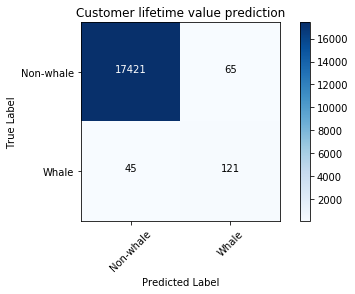

In [452]:
cm = confusion_matrix(y_test, y_pred_smote)
plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [453]:
# f1 score with SMOTE
f1_score(y_test, y_pred_smote, average=None)[1]

0.68749999999999989

## Regular (no over/undersampling)

In [454]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [455]:
%%time

clf.fit(X_train, y_train)

CPU times: user 56.6 s, sys: 280 ms, total: 56.9 s
Wall time: 22.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [456]:
y_pred = clf.predict(X_test)

In [457]:
clf.score(X_test, y_test)

0.99490142760027189

In [458]:
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.99463337384156347, 0.99490142760027189, 0.99473946888624476, None)

In [459]:
# random forest classifer, 5-fold cross-validation
clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='f1', verbose=True, cv=5)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


'F1 0.72 +/- 0.03'

In [460]:
# get F1 score per each of the folds
scores

array([ 0.72146119,  0.78899083,  0.70754717,  0.70093458,  0.70093458])

In [461]:
cm = confusion_matrix(y_test, y_pred)

In [462]:
def plot_confusion_matrix(cm,
                          classes=[0, 1],
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Source:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

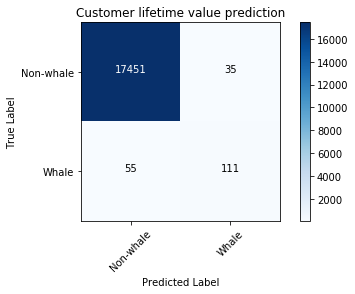

In [463]:
plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [464]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None)

array([ 0.99742798,  0.71153846])

In [465]:
# # feature importance calculation
# # get top n features

# importances = clf.feature_importances_
# n = 20

# zipped = sorted(zip(features, importances), key=lambda x: - x[1])

# for i, f in enumerate(zipped[:n]):
#     print("%d: Feature: %s, %.3f" % (i+1, f[0].get_name(), f[1]))
    
    
# top_features = [f[0] for f in zipped[:n]]
# top_features

In [466]:
def feature_importances(model, features, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(features, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0].get_name(), f[1]))

    return([f[0] for f in zipped[:n]])

In [467]:
top_features = feature_importances(clf, features_encoded, n=20)

1: Feature: sum_deposits, 0.175
2: Feature: cnt_deposits, 0.125
3: Feature: initial_deposit_amount, 0.060
4: Feature: account_type = SERIOUS_BUX, 0.041
5: Feature: account_type = FUN_BUX, 0.039
6: Feature: SUM(transactions.number_of_sessions), 0.038
7: Feature: SUM(transactions.total_session_duration), 0.032
8: Feature: MEAN(transactions.number_of_sessions), 0.029
9: Feature: MEAN(transactions.total_session_duration), 0.025
10: Feature: STD(transactions.conversion_to_sb), 0.022
11: Feature: STD(transactions.number_of_sessions), 0.022
12: Feature: MAX(transactions.total_session_duration), 0.021
13: Feature: MAX(transactions.conversion_to_sb), 0.020
14: Feature: MAX(transactions.number_of_sessions), 0.020
15: Feature: STD(transactions.total_session_duration), 0.019
16: Feature: SUM(transactions.conversion_to_sb), 0.018
17: Feature: MEAN(transactions.conversion_to_sb), 0.016
18: Feature: SUM(transactions.day_of_year), 0.015
19: Feature: MODE(transactions.account_status) = SERIOUS_BUX, 0.0

In [468]:
ft.save_features(top_features, "top_features")

### Retrain the classifier on top 20 features

In [469]:
# load in the features from before
top_features = ft.load_features("top_features", es)

In [470]:
%%time

fm = ft.calculate_feature_matrix(top_features,
                                 entityset=es,
                                 # cutoff_time = label_times,
                                 cutoff_time_in_index=True,
                                 verbose=False)

CPU times: user 18min 47s, sys: 2.66 s, total: 18min 50s
Wall time: 18min 54s


## Classification

In [471]:
X = fm.reset_index().merge(CurCV[['user_id', 'whale']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("whale")

In [472]:
# top 20 features
len(X.columns)

20

In [473]:
y.value_counts()

0    58250
1      589
Name: whale, dtype: int64

In [474]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [475]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [476]:
%%time

clf.fit(X_train, y_train)

CPU times: user 47.9 s, sys: 279 ms, total: 48.1 s
Wall time: 13.7 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [477]:
y_pred = clf.predict(X_test)

In [478]:
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.99725746  0.78666667]
recall: [ 0.99816996  0.71084337]
fscore: [ 0.9977135   0.74683544]
support: [17486   166]


In [479]:
# %%time

clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='f1', verbose=True, cv=5)
"F1 score %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


'F1 score 0.73 +/- 0.03'

In [480]:
scores

array([ 0.70222222,  0.79646018,  0.72146119,  0.72477064,  0.70909091])

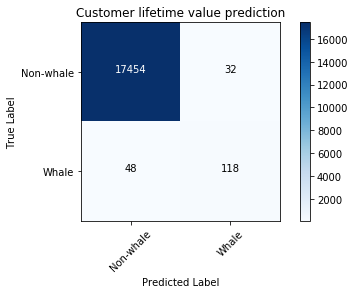

In [481]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [482]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score


# y_pred_proba = clf.predict_proba(X_test)
# average_precision = average_precision_score(y_test, y_pred)
# pr, re, _ = precision_recall_curve(y_test,y_pred,pos_label=1)


# plt.step(re, pr, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(re, pr, step='post', alpha=0.2,
#                  color='b')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))

In [483]:
# clf_cv.decision_path(X_test)

### 30% test set (Feb 17 cohort)

![title](img/30% test set  - Feb 17 cohort.png)

## 40% test set (Feb 17 cohort)

![title](img/40% test set - Feb 17 cohort.png)

## 30% test set (Feb 17 cohort, 30k users sample)
![title](img/confusion_matrix - 30.000 users - first pipeline.png)

## Regression

In [420]:
X = fm.reset_index().merge(CurCV[['user_id', 'curcv']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("curcv")

In [421]:
len(X.columns)

20

In [422]:
# average customer value
y.mean()

7.031610000000002

In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [424]:
y_train.describe()

count    10500.000000
mean         7.968665
std        182.495069
min        -18.560000
25%          0.000000
50%          0.000000
75%          0.000000
max      12735.330000
Name: curcv, dtype: float64

In [425]:
y_test.describe()

count    4500.000000
mean        4.845149
std        86.642488
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4235.600000
Name: curcv, dtype: float64

In [426]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [427]:
%%time


regr.fit(X_train, y_train)

CPU times: user 454 ms, sys: 11.9 ms, total: 466 ms
Wall time: 470 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [428]:
feature_importances(regr, features_encoded, n=20)

1: Feature: initial_deposit_amount, 0.760
2: Feature: network = Viral Invites, 0.078
3: Feature: title = Rookie Trader, 0.069
4: Feature: account_type = FUN_BUX, 0.031
5: Feature: network = BUX Website, 0.029
6: Feature: title = Experienced Trader, 0.027
7: Feature: cnt_deposits, 0.003
8: Feature: network = Appnext, 0.003
9: Feature: title = Pro Trader, 0.000
10: Feature: title = unknown, 0.000
11: Feature: network = Facebook Installs, 0.000
12: Feature: network = Organic, 0.000
13: Feature: network = TV, 0.000
14: Feature: network = Google Adwords Search, 0.000
15: Feature: network = Instagram Installs, 0.000
16: Feature: network = AdColony, 0.000
17: Feature: network = Finanzen.net, 0.000
18: Feature: network = unknown, 0.000
19: Feature: account_type = SERIOUS_BUX, 0.000
20: Feature: account_type = unknown, 0.000


[<Feature: initial_deposit_amount>,
 <Feature: network = Viral Invites>,
 <Feature: title = Rookie Trader>,
 <Feature: account_type = FUN_BUX>,
 <Feature: network = BUX Website>,
 <Feature: title = Experienced Trader>,
 <Feature: cnt_deposits>,
 <Feature: network = Appnext>,
 <Feature: title = Pro Trader>,
 <Feature: title = unknown>,
 <Feature: network = Facebook Installs>,
 <Feature: network = Organic>,
 <Feature: network = TV>,
 <Feature: network = Google Adwords Search>,
 <Feature: network = Instagram Installs>,
 <Feature: network = AdColony>,
 <Feature: network = Finanzen.net>,
 <Feature: network = unknown>,
 <Feature: account_type = SERIOUS_BUX>,
 <Feature: account_type = unknown>]

In [429]:
y_pred = regr.predict(X_test)

In [430]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [431]:
y_test.head()

11499    0.0
6475     0.0
13167    0.0
862      0.0
5970     0.0
Name: curcv, dtype: float64

In [432]:
r2_reg = r2_score(y_test, y_pred).round(3)
r2_reg

0.50800000000000001

In [433]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

6.58775311675
3689.43427066
60.740713452


In [434]:
test_set_pred = sum(y_pred)
test_set_true = sum(y_test)

test_set_pred, test_set_true

(26014.572203602893, 21803.169999999995)

In [435]:
test_set_benchmark = len(y_test) * CurCV['curcv'].mean()

test_set_benchmark, test_set_true

(31642.245000000006, 21803.169999999995)

In [436]:
y_benchmark = [CurCV['curcv'].mean() for i in range(0,len(y_test))]

In [437]:
print(mean_absolute_error(y_test, y_benchmark))
print(mean_squared_error(y_test, y_benchmark))
print(np.sqrt(mean_squared_error(y_test, y_benchmark)))

11.5028622489
7510.03314215
86.6604473918
